# An example with zero inflated negative binomial regression

From here: https://en.wikipedia.org/wiki/Negative_binomial_distribution

A negative binomial RV models the number of failures in a sequence of i.i.d Bernouilli trials before the a specified (non-random) number of successes (denoted $r$) occurrs. E.g. we can call "success" rolling a 6 on a 6-sided die and ask: "How many failures (non-6s) will occur before we roll the third ($r=3$) 6?" In this case, the probability of the number of non-6s will be negative binomial.


A generalization is to allow for $r$ to assume any positve real value. 

NB allows for letting mean $\neq$ variance, unlike Poisson distribution. 

# 1) Theory
again, https://en.wikipedia.org/wiki/Negative_binomial_distribution

Recall that a **Binomial** RV describes the distribution of the number of successes in $n$ independent Bernoulli trials with success probability $p$. 

**Example**: probability of getting exactly 2 heads in 6 tosses of a fair coin:

$$
\begin{align}
\mathbb{P}[X=2] &= \text{(number of ways of distributing 2 successes into a sequence of 6 trials)}\times(\mathbb{P}[\text{sucess}])^2\times(\mathbb{P}[\text{failure}])^{6-2}
\end{align}
$$

For the first part of this, the success can happen on trial 1 and 5, 1 and 2, 3 and 4 etc. So it is a problem of ${n \choose x}$. But, in each of these 2-out-of-6 sucesses, I need to get exactly a string of 2 sucesses and 4 losses. This happens with probability $(\mathbb{P}[\text{sucess}])^2\times(\mathbb{P}[\text{failure}])^{6-2}$. Hence the required probability is

$$
\begin{align}
\mathbb{P}[X=2] &= {6 \choose 2}\left(\frac{1}{2}\right)^2\left(\frac{1}{2}\right)^4 \\
&= \frac{6!}{2!4!}\frac{1}{64} \\
&= \frac{6\times 5}{2}\frac{1}{64}\\
&= \frac{15}{64}.
\end{align}
$$

With a **Negative Binomial** RV we are instead asking: how many times ($k$) will we fail until the $r$th success? So with $k$ failures and $r$ successes, there will be a total of $k+r$ Bernouilli trials. But we are interested in the number of failures **BEFORE** the $r$th success. So the total number of trials is $k+r-1$. We are now asking about the way of distributing $k$ failures among these. We therefore have (success probability $p$, $r$=number of successes, $k$=number of failures)

$$
\begin{align}
f(k;r,p) &= \mathbb{P}[X=k] = {k+r-1 \choose k}p^r(1-p)^k.
\end{align}
$$

Now one can extend the negative binomial distribution to the case where $r$ is any positive real, not necessarily integer. In that case:

$$
\begin{align}
{k+r-1 \choose k}p^r(1-p)^k &= \frac{(k+r-1)(k+r-2)...(r)(r-1)...(1))}{k!(r-1)!} \\
&= \frac{(k+r-1)(k+r-2)...(r)}{k!} \\
&= \frac{\Gamma(k+r)}{k!\Gamma(r)},
\end{align}
$$

where the binomial coefficient is extended to its real-values counterpart, the Gamma function (see wikipedia). Hence, the probabiluty mass function becomes:

$$
\begin{align}
f(k;r,p) &= \mathbb{P}[X=k] = \frac{\Gamma(k+r)}{k!\Gamma(r)}p^r(1-p)^k.
\end{align}
$$

In negative binomial regression, the distribution is specified in terms of the mean $m = \frac{pr}{1-p}$, hence $p=\frac{m}{m+r}$ and $1-p=\frac{r}{m+r}$. Substituting this:

$$
\begin{align}
f(k;r,p) &= \mathbb{P}[X=k] = \frac{\Gamma(k+r)}{k!\Gamma(r)}\left(\frac{m}{m+r}\right)^r\left(\frac{r}{m+r}\right)^k.
\end{align}
$$

For maximum likelihood estimation, see: https://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation

The **Zero Inflated Negative Binomial** regression model is then analogous to the ZIP model we saw in `_3_poisson_statsmodesl_zero_inflation`: we use a binary outcome model such as a logistic regression to model whether something does or does not happen and then we use a count model (in this case a negative binomial) to model the expected count of whatever we are interested in conditional on the thing happening. 

# 2) Example: fish caught in state park again

We consider the same example as we did in 2.2) in `_3_poisson_statsmodesl_zero_inflation`. The example is taken from here: https://stats.idre.ucla.edu/r/dae/zinb/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP as ZINB

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('https://stats.idre.ucla.edu/stat/data/fish.csv')

In [3]:
df.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [4]:
df.describe()

,nofish,livebait,camper,persons,child,xb,zg,count
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000
mean,0.296000,0.864000,0.588000,2.52800,0.684000,0.973796,0.252323,3.296000
std,0.457407,0.343476,0.493182,1.11273,0.850315,1.440277,2.102391,11.635028
min,0.000000,0.000000,0.000000,1.00000,0.000000,-3.275050,-5.625944,0.000000
25%,0.000000,1.000000,0.000000,2.00000,0.000000,0.008267,-1.252724,0.000000
50%,0.000000,1.000000,1.000000,2.00000,0.000000,0.954550,0.605079,0.000000
75%,1.000000,1.000000,1.000000,4.00000,1.000000,1.963855,1.993237,2.000000
max,1.000000,1.000000,1.000000,4.00000,3.000000,5.352674,4.263185,149.000000


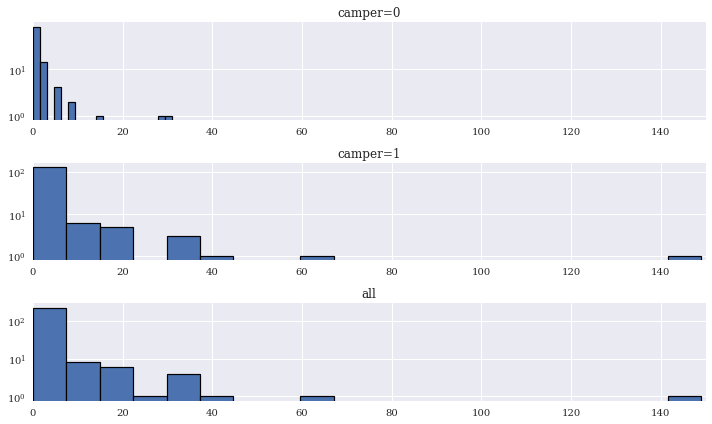

In [5]:
f, ax = plt.subplots(3,1,figsize=(10, 6))

ax[0].hist(df[df.camper==0]['count'], bins=20, edgecolor="k", linewidth=1.2)
ax[0].set_yscale('log')
ax[0].set_xlim([0,150])
ax[0].set_title('camper=0')
ax[1].hist(df[df.camper==1]['count'], bins=20, edgecolor="k", linewidth=1.2)
ax[1].set_yscale('log')
ax[1].set_xlim([0,150])
ax[1].set_title('camper=1')
ax[2].hist(df['count'], bins=20, edgecolor="k", linewidth=1.2)
ax[2].set_yscale('log')
ax[2].set_xlim([0,150])
ax[2].set_title('all')

f.tight_layout()

plt.show()

Note that the $p=2$ is for the choice between **NB1** model (variance = mean + $\alpha\times$mean) and the **NB2** model (variance = mean + $\alpha\times$mean$^2$). (see here: https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4).

In [6]:
endog_var = df['count'].values
exog_vars = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                            df.child.values.reshape(-1,1),
                            df.camper.values.reshape(-1,1)],
                           axis=1)
exog_vars_infl = np.concatenate([np.ones(df.shape[0]).reshape(-1,1),
                                 df.persons.values.reshape(-1,1)],
                                axis=1)
m = ZINB(endog = endog_var,
         exog = exog_vars,
         exog_infl=exog_vars_infl,
         inflation='logit',
         p=2).fit()

         Current function value: 1.731564
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/seb/py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [7]:
m.summary()

/home/seb/py36/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/seb/py36/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  250
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      247
Method:                                      MLE   Df Model:                            2
Date:                           Fri, 17 Apr 2020   Pseudo R-squ.:                 0.06793
Time:                                   00:29:44   Log-Likelihood:                -432.89
converged:                                 False   LL-Null:                       -464.44
Covariance Type:                       nonrobust   LLR p-value:                 1.989e-14
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     1.6027      0.836      1.917      0.055      -0.036       3.242
inflate_x1       -1.6661      0.679     -2.454      0.014      -2.997      -0.336
const             1.3709      0.256      5.353      0.000       0.869       1.873
x1               -1.5152      0.196     -7.747      0.000      -1.898      -1.132
x2                0.8791      0.269      3.265      0.001       0.351       1.407
alpha             2.6784      0.471      5.684      0.000       1.755       3.602
=================================================================================
"""

In [8]:
yhat = m.predict(exog=exog_vars, exog_infl=exog_vars_infl)

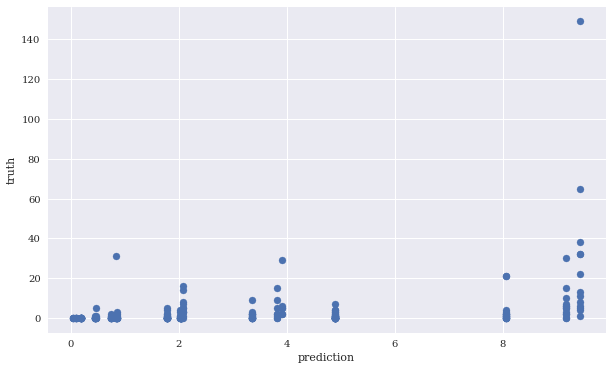

In [9]:
f, ax = plt.subplots(1,1,figsize=(10, 6))
ax.scatter(yhat, df['count'])
ax.set_xlabel('prediction')
ax.set_ylabel('truth')
plt.show()

**TODO** 

- add Vuong tests comparing ZINB to ordinary NB regression

- add boostrapped standard errors